In [10]:
## Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow_datasets as tfds
import tensorflow as tf
from tensorflow.keras import utils
import tensorflow_text as tf_text

In [11]:
## Utility functions
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])

In [12]:
## Read data
train_essays = pd.read_csv("/kaggle/input/llm-detect-ai-generated-text/train_essays.csv")
#test_essays = pd.read_csv("/kaggle/input/llm-detect-ai-generated-text/test_essays.csv")
train_prompts = pd.read_csv("/kaggle/input/llm-detect-ai-generated-text/train_prompts.csv")
ai_generated_train_essays = pd.read_csv("/kaggle/input/llm-generated-essays/ai_generated_train_essays.csv")
ai_generated_train_essays_gpt4 = pd.read_csv("/kaggle/input/llm-generated-essays/ai_generated_train_essays_gpt-4.csv")
train_essays = pd.concat([train_essays, ai_generated_train_essays, ai_generated_train_essays_gpt4])
train_essays['label'] = train_essays['generated']
train_essays.drop(["id", "prompt_id", "generated"], inplace=True, axis=1)
print(train_essays.shape)

daigt_external_dataset_1 = pd.read_csv("/kaggle/input/daigt-proper-train-dataset/train_drcat_01.csv")
daigt_external_dataset_2 = pd.read_csv("/kaggle/input/daigt-proper-train-dataset/train_drcat_02.csv")
daigt_external_dataset_3 = pd.read_csv("/kaggle/input/daigt-proper-train-dataset/train_drcat_03.csv")
daigt_external_dataset_4 = pd.read_csv("/kaggle/input/daigt-proper-train-dataset/train_drcat_04.csv")
daigt_external_dataset = pd.concat([daigt_external_dataset_1, daigt_external_dataset_2, daigt_external_dataset_3, daigt_external_dataset_4])
daigt_external_dataset.drop(["source", "essay_id", "prompt"], axis=1, inplace=True)
daigt_external_dataset_train = daigt_external_dataset[daigt_external_dataset.fold != 0].drop("fold", axis=1)
daigt_external_dataset_val = daigt_external_dataset[daigt_external_dataset.fold == 0].drop("fold", axis=1)
print(daigt_external_dataset.shape)

## Split the dataset
train_essays, val_essays = train_test_split(train_essays, test_size=0.33)
## Merge with external dataset
train_essays = pd.concat([daigt_external_dataset_train, train_essays])
val_essays = pd.concat([daigt_external_dataset_val, val_essays])

(2078, 2)
(159456, 3)


In [13]:
## Create dataset
# Create TensorFlow datasets from the DataFrames
batch_size = 16

train_dataset = tf.data.Dataset.from_tensor_slices(
    (train_essays['text'].values, train_essays['label'].values)
).batch(batch_size)

val_dataset = tf.data.Dataset.from_tensor_slices(
    (val_essays['text'].values, val_essays['label'].values)
).batch(batch_size)

#test_dataset = tf.data.Dataset.from_tensor_slices(
 #   (test_essays['text'].values)
#).batch(batch_size)

In [14]:
for text_batch, label_batch in train_dataset.take(1):
    for i in range(1):
        print("Question: ", text_batch.numpy()[i])
        print("Label:", label_batch.numpy()[i])

Question:  b'There are alot reasons to keep our the despised method of choosing the President. The First reason is because Certainty of Outcome, in the text its states that "The reason is that the winning candidate\'s share of the Electoral College invariably exceeds his share of the popular vote. Another example from the text is "Obama, he recieved 61.7 percent of the electoral vote compared to only 51.3 percent of the popular votes cast for him and Romney... because all of the states award electoral votes on a winner-take-all basis.\n\nAnother reason is that the Electiral College requires a presidential candidate to have trans-regional appeal,in that case, no region has enough electoral votes to elect a president, a solid regional favorite such as Romney was in the South , has no reason to campaign in those states because of the poor economy and because its not a wealthy state, he wont be able to campaign heavily. So he left with no votes and would have to find his Electoral College 

In [15]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64
VOCAB_SIZE = 1000

encoder = tf.keras.layers.TextVectorization(max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

In [16]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'to', 'and', 'a', 'of', 'in', 'that', 'is',
       'it', 'you', 'be', 'for', 'they', 'can', 'have', 'are', 'students',
       'i'], dtype='<U15')

In [17]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

history = model.fit(train_dataset, epochs=5,
                    validation_data=val_dataset,
                    validation_steps=30)

Epoch 1/5
8849/8849 ━━━━━━━━━━━━━━━━━━━━ 378s 42ms/step - accuracy: 0.9487 - loss: 0.1233 - val_accuracy: 0.9958 - val_loss: 0.0155
Epoch 2/5
8849/8849 ━━━━━━━━━━━━━━━━━━━━ 377s 43ms/step - accuracy: 0.9942 - loss: 0.0179 - val_accuracy: 0.9979 - val_loss: 0.0052
Epoch 3/5
8849/8849 ━━━━━━━━━━━━━━━━━━━━ 375s 42ms/step - accuracy: 0.9954 - loss: 0.0152 - val_accuracy: 0.9958 - val_loss: 0.0061
Epoch 4/5
8849/8849 ━━━━━━━━━━━━━━━━━━━━ 375s 42ms/step - accuracy: 0.9960 - loss: 0.0122 - val_accuracy: 0.9958 - val_loss: 0.0096
Epoch 5/5
8849/8849 ━━━━━━━━━━━━━━━━━━━━ 376s 42ms/step - accuracy: 0.9961 - loss: 0.0117 - val_accuracy: 0.9979 - val_loss: 0.0075


(0.0, 0.07115625301375986)

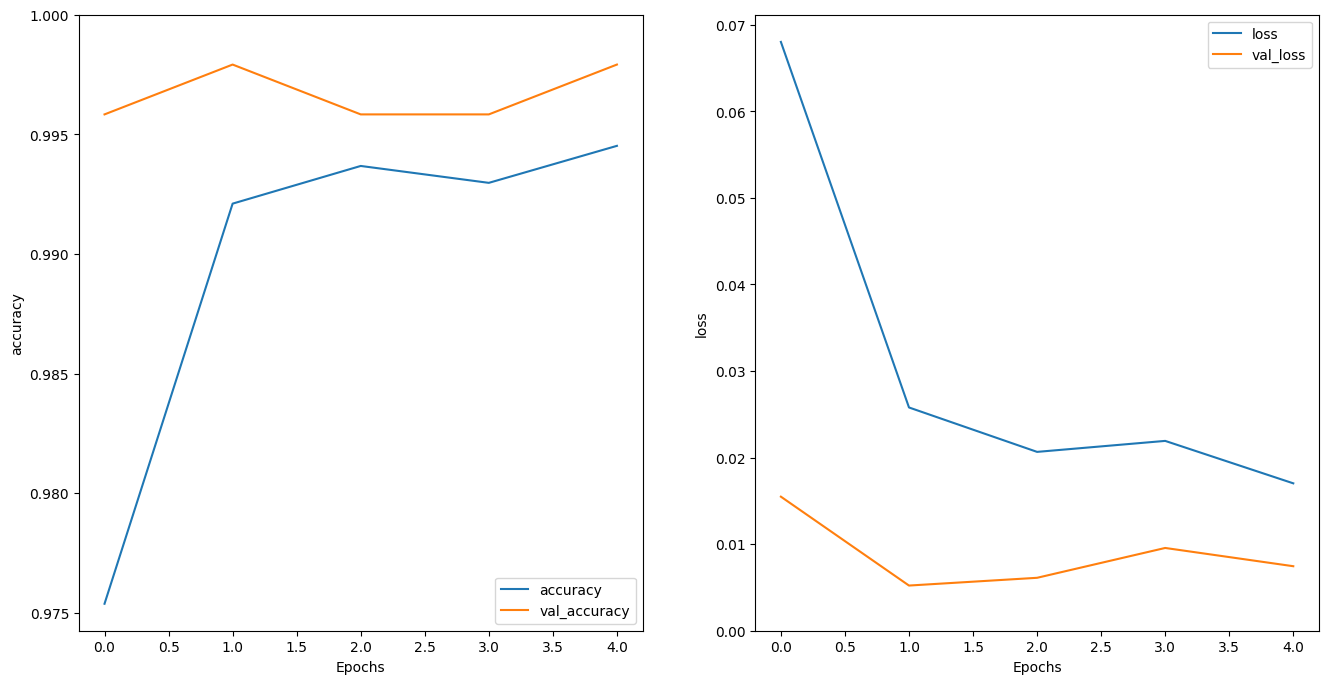

In [18]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)